# 5 PyTorch Going modular

## 1. Get data

Same data as before (pizza, steak, sushi).

In [1]:
%%writefile going_modular/get_data.py
"""
A function to fetch the training and testing data if it doesn't exist already.
"""
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it
if image_path.is_dir():
    print(f"{image_path} already exists")
    return
else:
    print(f"Creating {image_path} directory")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    print("Downloading data...")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

# Remove zip
os.remove(data_path / "pizza_steak_sushi.zip")
print("Done")

Writing going_modular/get_data.py


## 2. Create `Dataset`s and `DataLoader`s

We create a `create_dataloaders()` function to do the job for us :D

Then we write it to file using the line `%%writefile going_modular/data_setup.py`

In [6]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for image classification data.
"""

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
        train_dir: Path to training directory.
        test_dir: Path to testing directory.
        transform: torchvision transforms to perform on training and testing data.
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.

    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
        Where class_names is a list of the target classes.

    Example usage:
        train_dataloader, test_dataloader, class_names = \
            = create_dataloaders(train_dir=path/to/train_dir,
                                test_dir=path/to/test_dir,
                                transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
        pin_memory = True
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
        pin_memory = True
    )

    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


### 2.1 Utilizing `create_dataloaders()` function

In [24]:
# Prepare the arguments
from torchvision import transforms
import os
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [25]:
# Import data_setup.py and leverage newly created function
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=data_transform,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS)

## 3. Making a model (`model_builder.py`)

No more creating the TinyVGG model over and over, time to build it once and just use the function to create an instance whenever we want.

In [9]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.
    
    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/
    
    Args:
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers.
        output_shape: An integer indicating number of output units.
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x:torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


Writing going_modular/model_builder.py


### 3.1 Utilizing `model_builder()` function

In [10]:
import torch

from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [11]:
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 4. Creating `train_step()` and `test_step()` functions and `train()` to combine them.

In the last notebook, we had a few training functions:

1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - peformos train and test steps together for a given number of epochs and returns a results dictionary.

Since these will be the engine of our model training, we can put them all into a Python script called `engine.py`

In [12]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    
    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    
    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to hep minimize the loss function.
        device: A target device to compute on(e.g. "cuda" or "cpu)
    
    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy). For example:
        
        (0.1112, 0.8743)"""

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    
    Turns a target PyTorch model to "eval" model and then performs
    a forward pass on a testing dataset.
    
    Args:
        model: A PyTorch model to be tested.
        dataloader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        
    Returns:
        A tuple of testing loss and testing accuracy metrics.
        In the form (test_loss, test_accuracy). For example:
        
    (0.0223, 0.8985)
    """

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    Calculates, prints and stores evaluation metrics throughout.
    
    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        
    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for
        each epoch.
        In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
        For example if training for epochs=2: 
                    {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(1, epochs+1)):
        train_loss, train_acc = train_step(model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # Return the filled results at the end of the epochs
    return results

Writing going_modular/engine.py


### 4.1 Utilizing `train_step()`, `test_step()` and `train()` functions

In [13]:
import torch
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

EPOCHS = 5

In [14]:
from going_modular import engine

# Use train() by calling it from engine.py
results = engine.train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=EPOCHS,
            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3116
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3320 | test_loss: 1.0699 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0863 | train_acc: 0.4922 | test_loss: 1.0801 | test_acc: 0.5227
Epoch: 4 | train_loss: 1.0826 | train_acc: 0.4102 | test_loss: 1.0599 | test_acc: 0.5729
Epoch: 5 | train_loss: 1.0630 | train_acc: 0.4141 | test_loss: 1.0612 | test_acc: 0.5540


## 5. Creating a function to save the model (`utils.py`)

We can create a function to save the model to a file, so we can use it later.

In [15]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.
    
    Args:
        model: A target PyTorch model to save.
        target_dir: A directory for saving the model to.
        model_name: A filename for the saved model. Should include
            either ".pth" or ".pt" as the file extension.
    
    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="model_name.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
               f=model_save_path)


Writing going_modular/utils.py


### 5.1 Utilizing `save_model()` function

In [16]:
from going_modular import utils

# Save the model to file
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_model_0.pth")

[INFO] Saving model to: models\05_model_0.pth


## 6. Putting it all together

PyTorch repositories often combine all of their functionality together in a `train.py` file.

This file is essentially saying "train the model using whatever data is available".

In our `train.py` file, we'll combine all of the functionality of the other Pythoc scripts we've created and use it to train a model.

This way we can train a PyTorch model using a single line of code on the command line:

```bash
python train.py
```

To create `train.py` we'll go through the following steps:
1. Import various dependencies, namely `torch`, `os`, `torchvision.transforms` and all of the script from the `going_modular` directory, `data_setup`, `engine`, `model_builder`, `utils`.
2. Note: Since `train.py` will be inside the `going_modular` directory, we can import the other modules via `import ...` rather than `from going_modular import ...`.
3. Setup various hyperparameters such as batch size, number of epochs, learning rate and number of hidden units (these could be set in the future via Python's `argparse`).
4. Setup the training and test directories.
5. Setup device-agnostic code.
6. Create the necessary data transforms.
7. Create the DataLoaders using `data_setup.py`.
8. Create the model using `model_builder.py`.
9. Setup the loss function and optimizer.
10. Train the model using `engine.py`.
11. Save the model using `utils.py`.

In [4]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code
"""

import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create DataLoaders with hep from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with hep from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_model_1.pth")


Overwriting going_modular/train.py


In [1]:
!python going_modular/train.py


Epoch: 1 | train_loss: 1.1076 | train_acc: 0.3047 | test_loss: 1.0973 | test_acc: 0.2604

Epoch: 2 | train_loss: 1.1033 | train_acc: 0.3008 | test_loss: 1.0700 | test_acc: 0.5417

Epoch: 3 | train_loss: 1.1109 | train_acc: 0.2812 | test_loss: 1.0830 | test_acc: 0.2708

Epoch: 4 | train_loss: 1.0815 | train_acc: 0.4883 | test_loss: 1.1068 | test_acc: 0.3854

Epoch: 5 | train_loss: 1.0798 | train_acc: 0.3359 | test_loss: 1.1213 | test_acc: 0.2604
[INFO] Saving model to: models\05_model_1.pth



100%|██████████| 5/5 [01:42<00:00, 20.42s/it]


## 7. Creating a function to make predictions on new data (`predict.py`)

Arguments:
- `model_path` - the path to the trained model.
- `image_path` - the path to the image to make predictions on.
- `transform` - the image transform to use (optional).
- `classes` - the classes the model is trained on (optional).
- `device` - the device to make predictions on (optional).

In [30]:
%%writefile going_modular/predict.py

import torch

import torchvision
from torchvision import transforms
from pathlib import Path
from typing import List
from matplotlib import pyplot as plt

from going_modular import model_builder

def pred_and_plot_image(model_path: str,
                        image_path: str,
                        class_names: List[str] = None,
                        transform: transforms.Compose = None,
                        device: torch.device = "cpu"):
    """Makes a prediction on a target image with a trained model and
    plots the image and prediction

    Args:
        model_path: Path to the saved PyTorch model.
        image_path: Path to the image to make a prediction on.
        class_names: An optional list of class names for the target dataset.
        transform: An optional sequence of transformations to perform on the image.
        device: A target device to perform the model prediction on.
    
    Returns:
        None, plots an image and prediction.

    Example usage:
    pred_and_plot_image(model_path="models/model_0.pth",
                        image_path="data/pizza_steak_sushi/test/sushi/100810.jpg",
                        class_names=["pizza", "steak", "sushi"],
                        transform=data_transform,
                        device="cuda")
    """
    # Create new model
    # Hardcoding the model type and hidden_units because I can :)
    model = model_builder.TinyVGG(input_shape=3,
                                  hidden_units=10,
                                  output_shape=3)
    
    # Load the model from path
    model.load_state_dict(torch.load(f=model_path))

    # Load an image, divide by 255 to normalize
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

    # Add the batch dimension
    target_image = target_image.unsqueeze(0)

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Put model on the target device
    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image_pred = model(target_image.to(device))

        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # Plot the image
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension, rearrange

    if class_names:
        target_label = class_names[torch.argmax(target_image_pred_probs)]
        title = f"Pred: {target_label} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {torch.argmax(target_image_pred_probs)} | Prob: {target_image_pred_probs.max():.3f}"    
    plt.title(title)
    plt.axis('off')  

Writing going_modular/predict.py


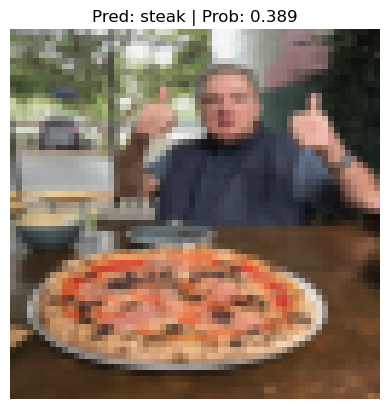

In [31]:
from going_modular import predict

custom_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
])

predict.pred_and_plot_image(model_path="models/05_model_1.pth",
                            image_path="data/04-pizza-dad.jpeg",
                            class_names=class_names,
                            transform=custom_data_transform,
                            device="cuda")